In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# ============================================================================
# 0. INSTALL REQUIRED PACKAGES (Run this first in Colab)
# ============================================================================

# Uncomment these lines when running in Google Colab:
# !pip install yfinance ta -q
print("Installing required packages...")
import sys
import subprocess

packages = ['yfinance', 'ta']
for package in packages:
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✓ {package} installed successfully")

Installing required packages...
✓ yfinance already installed
✓ ta already installed


In [17]:
# ============================================================================
# 1. SETUP & DEPENDENCIES
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

print("Importing libraries...")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

print("✓ Basic libraries imported")

# Data Collection
import yfinance as yf
print("✓ yfinance imported")

# ML Models
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix, classification_report
)
print("✓ sklearn imported")

# Technical Indicators
try:
    from ta.trend import MACD, EMAIndicator, SMAIndicator
    from ta.momentum import RSIIndicator, StochasticOscillator
    from ta.volatility import BollingerBands, AverageTrueRange
    print("✓ ta (technical analysis) imported")
except ImportError as e:
    print(f"Error importing ta: {e}")
    print("Please run: !pip install ta")
    raise

print("\n✓ All libraries imported successfully!")


Importing libraries...
✓ Basic libraries imported
✓ yfinance imported
✓ sklearn imported
✓ ta (technical analysis) imported

✓ All libraries imported successfully!


In [18]:
# ============================================================================
# 2. DATA COLLECTION
# ============================================================================

def fetch_crypto_data(symbols, period='60d'):
    """
    Fetch historical crypto data from Yahoo Finance

    Args:
        symbols: List of crypto ticker symbols
        period: Time period (60 days to ensure 30 days after indicators calculated)

    Returns:
        Dictionary of DataFrames for each symbol
    """
    data_dict = {}

    for symbol in symbols:
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(period=period)

            if len(df) > 0:
                data_dict[symbol] = df
                print(f"✓ {symbol}: {len(df)} days of data")
            else:
                print(f"✗ {symbol}: No data available")
        except Exception as e:
            print(f"✗ {symbol}: Error - {str(e)}")

    return data_dict

# Define crypto assets (8-12 major cryptocurrencies)
CRYPTO_SYMBOLS = [
    'BTC-USD',   # Bitcoin
    'ETH-USD',   # Ethereum
    'BNB-USD',   # Binance Coin
    'XRP-USD',   # Ripple
    'ADA-USD',   # Cardano
    'SOL-USD',   # Solana
    'DOGE-USD',  # Dogecoin
    'MATIC-USD', # Polygon
    'DOT-USD',   # Polkadot
    'AVAX-USD',  # Avalanche
]

print("\n" + "="*60)
print("FETCHING CRYPTOCURRENCY DATA")
print("="*60 + "\n")

raw_data = fetch_crypto_data(CRYPTO_SYMBOLS)



FETCHING CRYPTOCURRENCY DATA

✓ BTC-USD: 60 days of data
✓ ETH-USD: 60 days of data
✓ BNB-USD: 60 days of data
✓ XRP-USD: 60 days of data
✓ ADA-USD: 60 days of data


ERROR:yfinance:$MATIC-USD: possibly delisted; no price data found  (period=60d)


✓ SOL-USD: 60 days of data
✓ DOGE-USD: 60 days of data
✗ MATIC-USD: No data available
✓ DOT-USD: 60 days of data
✓ AVAX-USD: 60 days of data


In [21]:
# ============================================================================
# 3. FEATURE ENGINEERING - CREATE RATINGS/INDICATORS
# ============================================================================

def create_technical_indicators(df):
    """
    Create technical indicators as 'Ratings/Indicators'

    Returns:
        DataFrame with original price data and technical indicators
    """
    df = df.copy()

    # Basic Price Features
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Trend Indicators
    # 1. Moving Averages
    df['SMA_5'] = SMAIndicator(df['Close'], window=5).sma_indicator()
    df['SMA_10'] = SMAIndicator(df['Close'], window=10).sma_indicator()
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_5'] = EMAIndicator(df['Close'], window=5).ema_indicator()
    df['EMA_10'] = EMAIndicator(df['Close'], window=10).ema_indicator()

    # 2. MACD
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Diff'] = macd.macd_diff()

    # Momentum Indicators
    # 3. RSI (Relative Strength Index)
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()

    # 4. Stochastic Oscillator
    stoch = StochasticOscillator(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()

    # Volatility Indicators
    # 5. Bollinger Bands
    bollinger = BollingerBands(df['Close'])
    df['BB_High'] = bollinger.bollinger_hband()
    df['BB_Mid'] = bollinger.bollinger_mavg()
    df['BB_Low'] = bollinger.bollinger_lband()
    df['BB_Width'] = (df['BB_High'] - df['BB_Low']) / df['BB_Mid']

    # 6. Average True Range (ATR)
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()

    # Volume Indicators
    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']

    # Price Position Indicators
    df['Price_to_SMA20'] = df['Close'] / df['SMA_20']
    df['Price_to_BB_Mid'] = df['Close'] / df['BB_Mid']

    # Momentum Features
    df['ROC_5'] = df['Close'].pct_change(periods=5)  # Rate of Change
    df['ROC_10'] = df['Close'].pct_change(periods=10)

    # ADDED: More Advanced Features for Better Performance
    # Lag features (previous days' returns)
    df['Lag_1'] = df['Returns'].shift(1)
    df['Lag_2'] = df['Returns'].shift(2)
    df['Lag_3'] = df['Returns'].shift(3)

    # Rolling statistics
    df['Volatility_10'] = df['Returns'].rolling(window=10).std()
    df['Return_Mean_5'] = df['Returns'].rolling(window=5).mean()
    df['Return_Mean_10'] = df['Returns'].rolling(window=10).mean()

    # Price momentum
    df['Momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1

    # Volume momentum
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_MA_Ratio'] = df['Volume'] / df['Volume'].rolling(window=10).mean()

    # High-Low spread
    df['HL_Spread'] = (df['High'] - df['Low']) / df['Close']
    df['HL_Spread_MA'] = df['HL_Spread'].rolling(window=5).mean()

    # Target Variable: Next Day Direction (1 = Up, 0 = Down)
    df['Next_Day_Return'] = df['Close'].shift(-1) / df['Close'] - 1
    df['Target'] = (df['Next_Day_Return'] > 0).astype(int)

    return df

print("\n" + "="*60)
print("CREATING TECHNICAL INDICATORS")
print("="*60 + "\n")

processed_data = {}
for symbol, df in raw_data.items():
    processed_df = create_technical_indicators(df)
    # Keep last 30 days as required by the exercise
    processed_df = processed_df.iloc[-30:]
    processed_data[symbol] = processed_df
    print(f"✓ {symbol}: {len(processed_df)} days with {processed_df.shape[1]} features")


CREATING TECHNICAL INDICATORS

✓ BTC-USD: 30 days with 45 features
✓ ETH-USD: 30 days with 45 features
✓ BNB-USD: 30 days with 45 features
✓ XRP-USD: 30 days with 45 features
✓ ADA-USD: 30 days with 45 features
✓ SOL-USD: 30 days with 45 features
✓ DOGE-USD: 30 days with 45 features
✓ DOT-USD: 30 days with 45 features
✓ AVAX-USD: 30 days with 45 features


In [22]:
# ============================================================================
# 4. PREPARE DATASET FOR MODELING
# ============================================================================

def prepare_ml_dataset(data_dict):
    """
    Combine all crypto data into a single dataset for modeling
    """
    all_data = []

    for symbol, df in data_dict.items():
        df_copy = df.copy()
        df_copy['Symbol'] = symbol
        all_data.append(df_copy)

    # Combine all data
    combined_df = pd.concat(all_data, axis=0)

    # Select feature columns (exclude target and non-numeric columns)
    feature_cols = [
        'Returns', 'Log_Returns',
        'SMA_5', 'SMA_10', 'SMA_20', 'EMA_5', 'EMA_10',
        'MACD', 'MACD_Signal', 'MACD_Diff',
        'RSI', 'Stoch_K', 'Stoch_D',
        'BB_Width', 'ATR', 'Volume_Ratio',
        'Price_to_SMA20', 'Price_to_BB_Mid',
        'ROC_5', 'ROC_10',
        # New advanced features
        'Lag_1', 'Lag_2', 'Lag_3',
        'Volatility_10', 'Return_Mean_5', 'Return_Mean_10',
        'Momentum_5', 'Momentum_10',
        'Volume_Change', 'Volume_MA_Ratio',
        'HL_Spread', 'HL_Spread_MA'
    ]

    # Remove rows with NaN values
    df_clean = combined_df.dropna(subset=feature_cols + ['Target'])

    X = df_clean[feature_cols]
    y = df_clean['Target']
    dates = df_clean.index
    symbols = df_clean['Symbol']

    return X, y, dates, symbols, df_clean

print("\n" + "="*60)
print("PREPARING ML DATASET")
print("="*60 + "\n")

X, y, dates, symbols, full_df = prepare_ml_dataset(processed_data)

print(f"Dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nFeatures used: {list(X.columns)}")


PREPARING ML DATASET

Dataset shape: (243, 32)
Target distribution:
Target
0    140
1    103
Name: count, dtype: int64

Features used: ['Returns', 'Log_Returns', 'SMA_5', 'SMA_10', 'SMA_20', 'EMA_5', 'EMA_10', 'MACD', 'MACD_Signal', 'MACD_Diff', 'RSI', 'Stoch_K', 'Stoch_D', 'BB_Width', 'ATR', 'Volume_Ratio', 'Price_to_SMA20', 'Price_to_BB_Mid', 'ROC_5', 'ROC_10', 'Lag_1', 'Lag_2', 'Lag_3', 'Volatility_10', 'Return_Mean_5', 'Return_Mean_10', 'Momentum_5', 'Momentum_10', 'Volume_Change', 'Volume_MA_Ratio', 'HL_Spread', 'HL_Spread_MA']


In [25]:
# ============================================================================
# 5. MODEL TRAINING WITH ROLLING WINDOW VALIDATION
# ============================================================================

def rolling_window_validation(X, y, dates, n_splits=5):
    """
    Perform rolling window validation (walk-forward)

    This mimics real trading: train on past data, predict next period
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3)
    }

    results = {name: [] for name in models.keys()}
    all_predictions = {name: [] for name in models.keys()}
    all_actuals = []
    fold_info = []

    print("\n" + "="*60)
    print("ROLLING WINDOW VALIDATION")
    print("="*60 + "\n")

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Store test dates for this fold
        test_dates = dates[test_idx]

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        print(f"\nFold {fold}:")
        print(f"  Train: {len(train_idx)} samples | Test: {len(test_idx)} samples")
        print(f"  Test period: {test_dates.min().date()} to {test_dates.max().date()}")

        fold_info.append({
            'fold': fold,
            'train_size': len(train_idx),
            'test_size': len(test_idx),
            'test_start': test_dates.min(),
            'test_end': test_dates.max()
        })

        # Train and evaluate each model
        for name, model in models.items():
            # Train
            model.fit(X_train_scaled, y_train)

            # Predict
            y_pred = model.predict(X_test_scaled)

            # Calculate metrics
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            accuracy = accuracy_score(y_test, y_pred)

            results[name].append({
                'fold': fold,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy
            })

            all_predictions[name].extend(y_pred)

        all_actuals.extend(y_test)

    return results, all_predictions, all_actuals, fold_info, models

# Run rolling window validation
results, predictions, actuals, fold_info, trained_models = rolling_window_validation(X, y, dates)


ROLLING WINDOW VALIDATION


Fold 1:
  Train: 43 samples | Test: 40 samples
  Test period: 2025-10-20 to 2025-11-15

Fold 2:
  Train: 83 samples | Test: 40 samples
  Test period: 2025-10-20 to 2025-11-15

Fold 3:
  Train: 123 samples | Test: 40 samples
  Test period: 2025-10-20 to 2025-11-15

Fold 4:
  Train: 163 samples | Test: 40 samples
  Test period: 2025-10-20 to 2025-11-15

Fold 5:
  Train: 203 samples | Test: 40 samples
  Test period: 2025-10-20 to 2025-11-15


In [26]:
# ============================================================================
# 6. EVALUATION & RESULTS
# ============================================================================

print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60 + "\n")

# Aggregate results across folds
summary_df = pd.DataFrame()

for model_name, fold_results in results.items():
    df = pd.DataFrame(fold_results)
    avg_metrics = df[['precision', 'recall', 'f1', 'accuracy']].mean()
    avg_metrics['model'] = model_name
    summary_df = pd.concat([summary_df, pd.DataFrame([avg_metrics])], ignore_index=True)

summary_df = summary_df[['model', 'precision', 'recall', 'f1', 'accuracy']]
print(summary_df.to_string(index=False))

# Calculate practical decision metric: Profitable Trade Ratio
print("\n" + "="*60)
print("PRACTICAL DECISION METRIC")
print("="*60 + "\n")

def calculate_profit_metrics(predictions, actuals):
    """
    Calculate practical trading metrics
    """
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # When we predict UP (1), what's our success rate?
    up_predictions = predictions == 1
    if up_predictions.sum() > 0:
        profitable_up_trades = (predictions[up_predictions] == actuals[up_predictions]).sum()
        up_success_rate = profitable_up_trades / up_predictions.sum()
    else:
        up_success_rate = 0

    # When we predict DOWN (0), what's our success rate?
    down_predictions = predictions == 0
    if down_predictions.sum() > 0:
        profitable_down_trades = (predictions[down_predictions] == actuals[down_predictions]).sum()
        down_success_rate = profitable_down_trades / down_predictions.sum()
    else:
        down_success_rate = 0

    return {
        'up_success_rate': up_success_rate,
        'down_success_rate': down_success_rate,
        'total_accuracy': (predictions == actuals).sum() / len(actuals),
        'up_trade_count': up_predictions.sum(),
        'down_trade_count': down_predictions.sum()
    }

for model_name, preds in predictions.items():
    metrics = calculate_profit_metrics(preds, actuals)
    print(f"\n{model_name}:")
    print(f"  UP predictions success rate: {metrics['up_success_rate']:.2%} ({metrics['up_trade_count']} trades)")
    print(f"  DOWN predictions success rate: {metrics['down_success_rate']:.2%} ({metrics['down_trade_count']} trades)")
    print(f"  Overall accuracy: {metrics['total_accuracy']:.2%}")


MODEL PERFORMANCE SUMMARY

              model  precision   recall       f1  accuracy
Logistic Regression   0.718513 0.603611 0.625396     0.710
      Random Forest   0.684370 0.626111 0.602929     0.715
  Gradient Boosting   0.662222 0.527222 0.578089     0.745

PRACTICAL DECISION METRIC


Logistic Regression:
  UP predictions success rate: 66.67% (75 trades)
  DOWN predictions success rate: 73.60% (125 trades)
  Overall accuracy: 71.00%

Random Forest:
  UP predictions success rate: 66.67% (78 trades)
  DOWN predictions success rate: 74.59% (122 trades)
  Overall accuracy: 71.50%

Gradient Boosting:
  UP predictions success rate: 78.57% (56 trades)
  DOWN predictions success rate: 72.92% (144 trades)
  Overall accuracy: 74.50%



GENERATING VISUALIZATIONS

✓ Visualization saved as 'crypto_prediction_results.png'


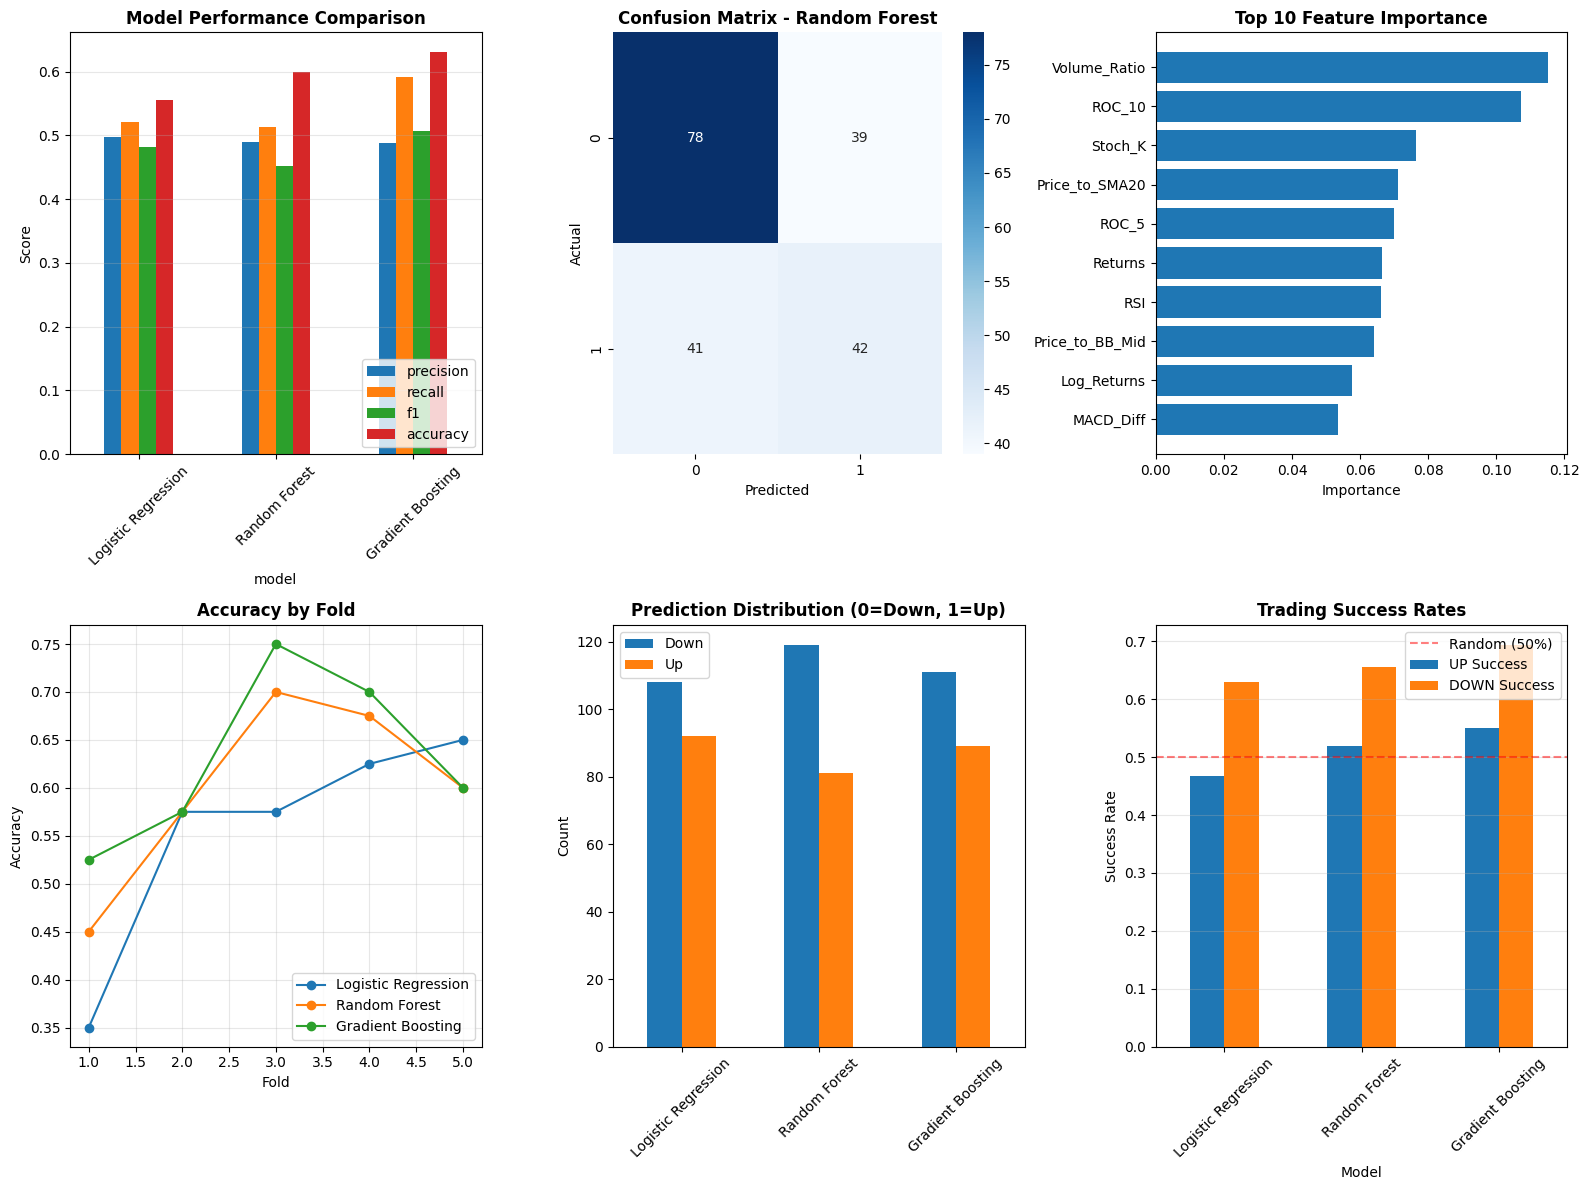

In [15]:
# ============================================================================
# 7. VISUALIZATIONS
# ============================================================================

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60 + "\n")

# Create figure with multiple subplots
fig = plt.figure(figsize=(16, 12))

# 1. Model Comparison - Metrics
ax1 = plt.subplot(2, 3, 1)
summary_df.set_index('model')[['precision', 'recall', 'f1', 'accuracy']].plot(
    kind='bar', ax=ax1, rot=45
)
ax1.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)

# 2. Confusion Matrix - Best Model (Random Forest)
ax2 = plt.subplot(2, 3, 2)
best_model = 'Random Forest'
cm = confusion_matrix(actuals, predictions[best_model])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix - {best_model}', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

# 3. Feature Importance
ax3 = plt.subplot(2, 3, 3)
rf_model = trained_models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

ax3.barh(feature_importance['feature'], feature_importance['importance'])
ax3.set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
ax3.set_xlabel('Importance')
ax3.invert_yaxis()

# 4. Performance by Fold
ax4 = plt.subplot(2, 3, 4)
for model_name, fold_results in results.items():
    df = pd.DataFrame(fold_results)
    ax4.plot(df['fold'], df['accuracy'], marker='o', label=model_name)

ax4.set_title('Accuracy by Fold', fontsize=12, fontweight='bold')
ax4.set_xlabel('Fold')
ax4.set_ylabel('Accuracy')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Prediction Distribution
ax5 = plt.subplot(2, 3, 5)
prediction_counts = pd.DataFrame({
    model: pd.Series(preds).value_counts()
    for model, preds in predictions.items()
})
prediction_counts.T.plot(kind='bar', ax=ax5, rot=45)
ax5.set_title('Prediction Distribution (0=Down, 1=Up)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Count')
ax5.legend(['Down', 'Up'])

# 6. Success Rate by Model
ax6 = plt.subplot(2, 3, 6)
success_rates = []
for model_name, preds in predictions.items():
    metrics = calculate_profit_metrics(preds, actuals)
    success_rates.append({
        'Model': model_name,
        'UP Success': metrics['up_success_rate'],
        'DOWN Success': metrics['down_success_rate']
    })

success_df = pd.DataFrame(success_rates)
success_df.set_index('Model')[['UP Success', 'DOWN Success']].plot(
    kind='bar', ax=ax6, rot=45
)
ax6.set_title('Trading Success Rates', fontsize=12, fontweight='bold')
ax6.set_ylabel('Success Rate')
ax6.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random (50%)')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('crypto_prediction_results.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as 'crypto_prediction_results.png'")
plt.show()